# Tutorial : Building an AWS SageMaker End-to-end Workflow with BentoML

# Introduction

### Description: 

This tutorial provides an end-to-end guide using BentoML with AWS SageMaker -- a machine learning model training platform. It demonstrates the workflow of integrating BentoML with SageMaker, including: setting up a SageMaker notebook instance, model training, creating an S3 bucket, uploading the BentoService bundle into S3, and deploying the BentoML packaged model to SageMaker as an API endpoint using the BentoML CLI tool. 

For demonstration, this tutorial uses the IMDB movie review sentiment dataset with BERT and Tensorflow 2.0.(please note: the following model is a modification of the original version: https://github.com/kpe/bert-for-tf2/blob/master/examples/gpu_movie_reviews.ipynb)

### Objectives: 

- demonstrates an end-to-end workflow of using BentoML with AWS SageMaker
- deploys and tests API endpoints to the cloud 
- provides two ways of API server local testing using BentoML CLI tool


## 1. Create a SageMaker notebook instance 

For model training in SageMaker, we will start by creating a **notebook instance**. After logging into the AWS management console -- type SageMaker to launch the service. From the SageMaker dashboard, select Notebook instances. Go ahead enter a notebook name and select the instance type 

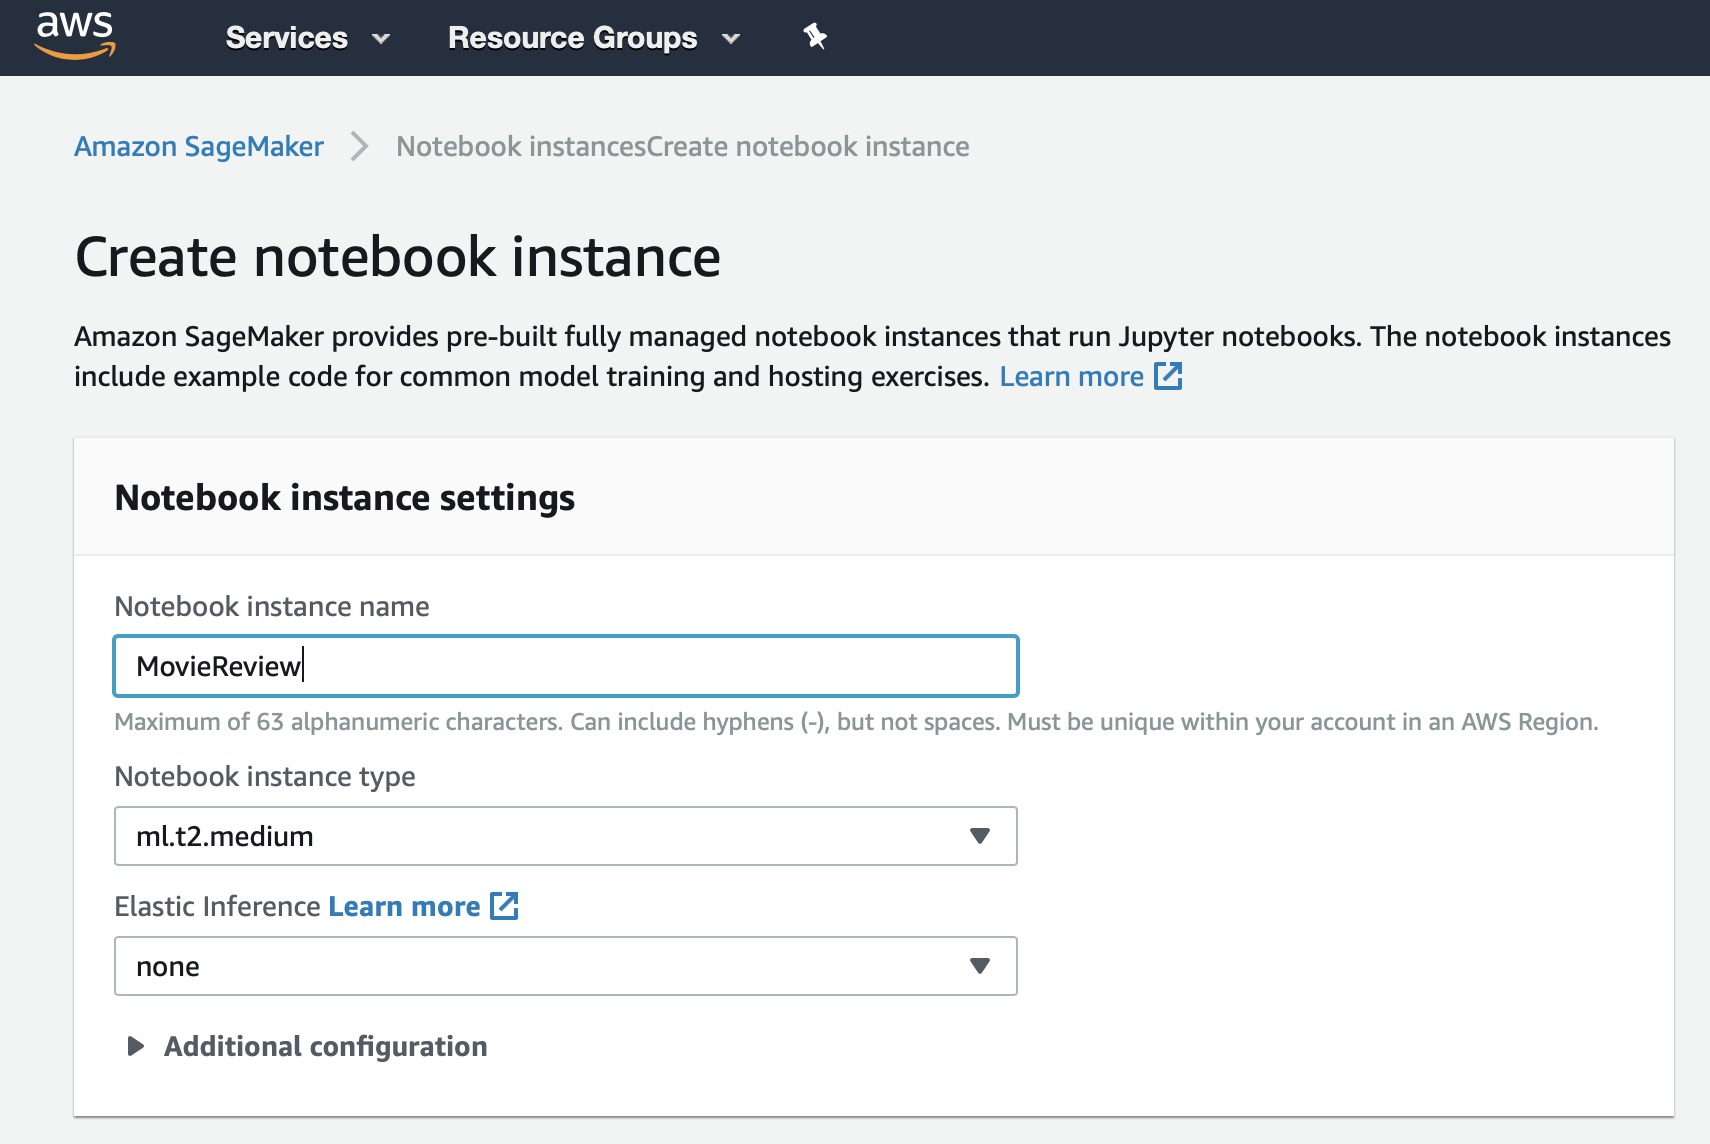

Next,under **Permissions and encryption**, select **Create a new role** or **choosing an existing role**. This allows both the notebook instance and user to access and upload data to Amazon S3. Then, select Any S3 bucket, which allows your SageMaker to access all S3 buckets in your account.

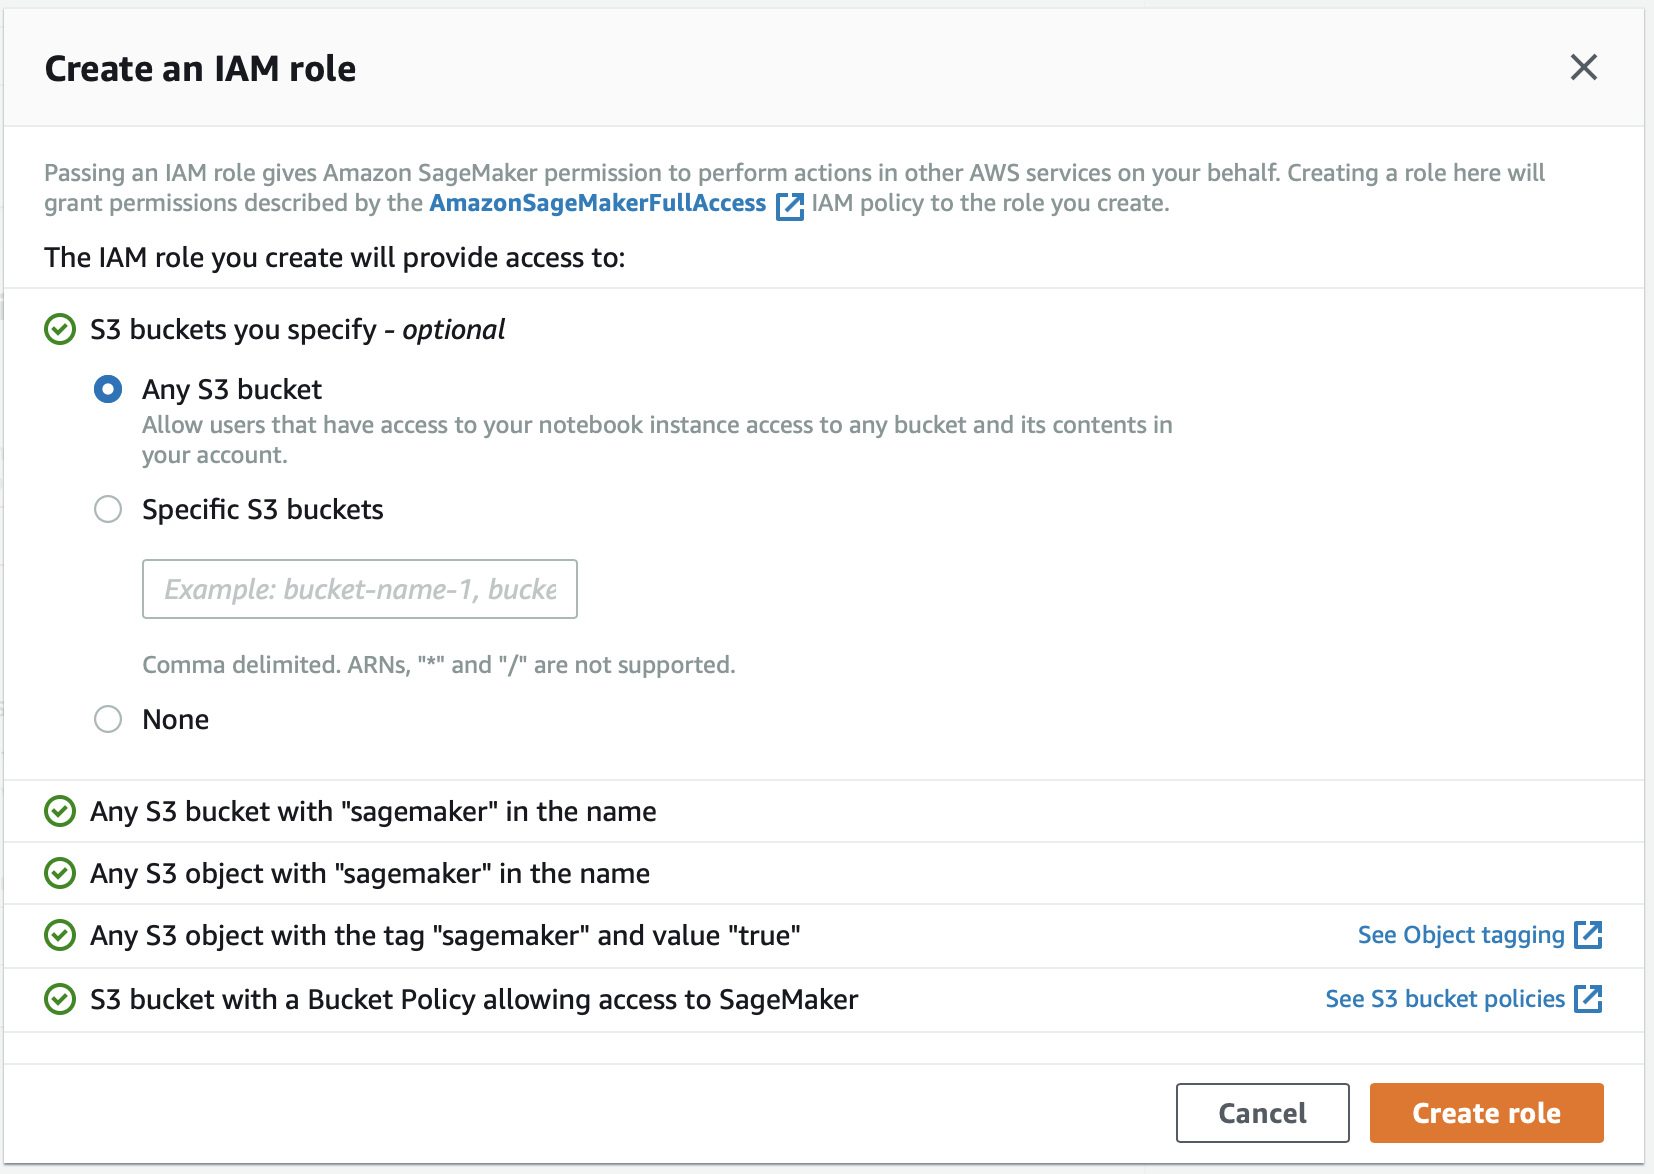

After the notebook instance is created, the status will change from pending to **InService**. Select Open Jupyter under Actions, and choose **Conda_python 3** under New tab to launch the Jupyter notebook within SageMaker. 

Note: SageMaker also provides a local model through pip install SageMaker.

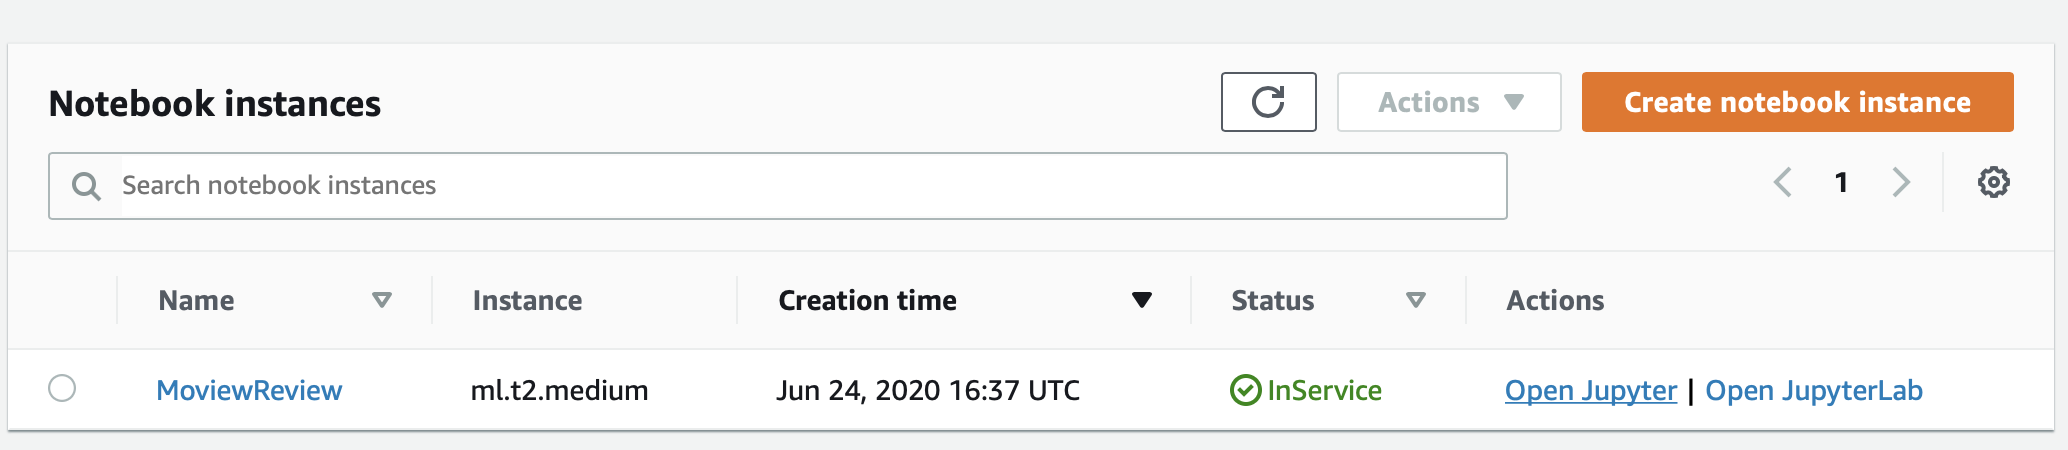



Finally to prepare for the model training, let's import some libraries -- Boto3 and SageMaker and set up the IAM role. Boto3 is the AWS SDK for Python, which makes it easier to integrate our model with AWS services such as Amazon S3

In [ ]:
import boto3, sagemaker
from sagemaker import get_execution_role

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/bert-moviereview-bento'
my_region = boto3.session.Session().region_name # set the region of the instance

In this step, we will create an S3 bucket named movie-review-dataset to store the dataset. Users could click on the bucket name and upload the dataset directly into S3. Alternatively, for cost-efficiency, users could train the model locally using the SageMaker local mode

In [7]:
bucket_name = 'movie-review-dataset'
s3 = boto3.resource('s3')
s3.create_bucket(Bucket=bucket_name)

s3.Bucket(name='movie-review-dataset')

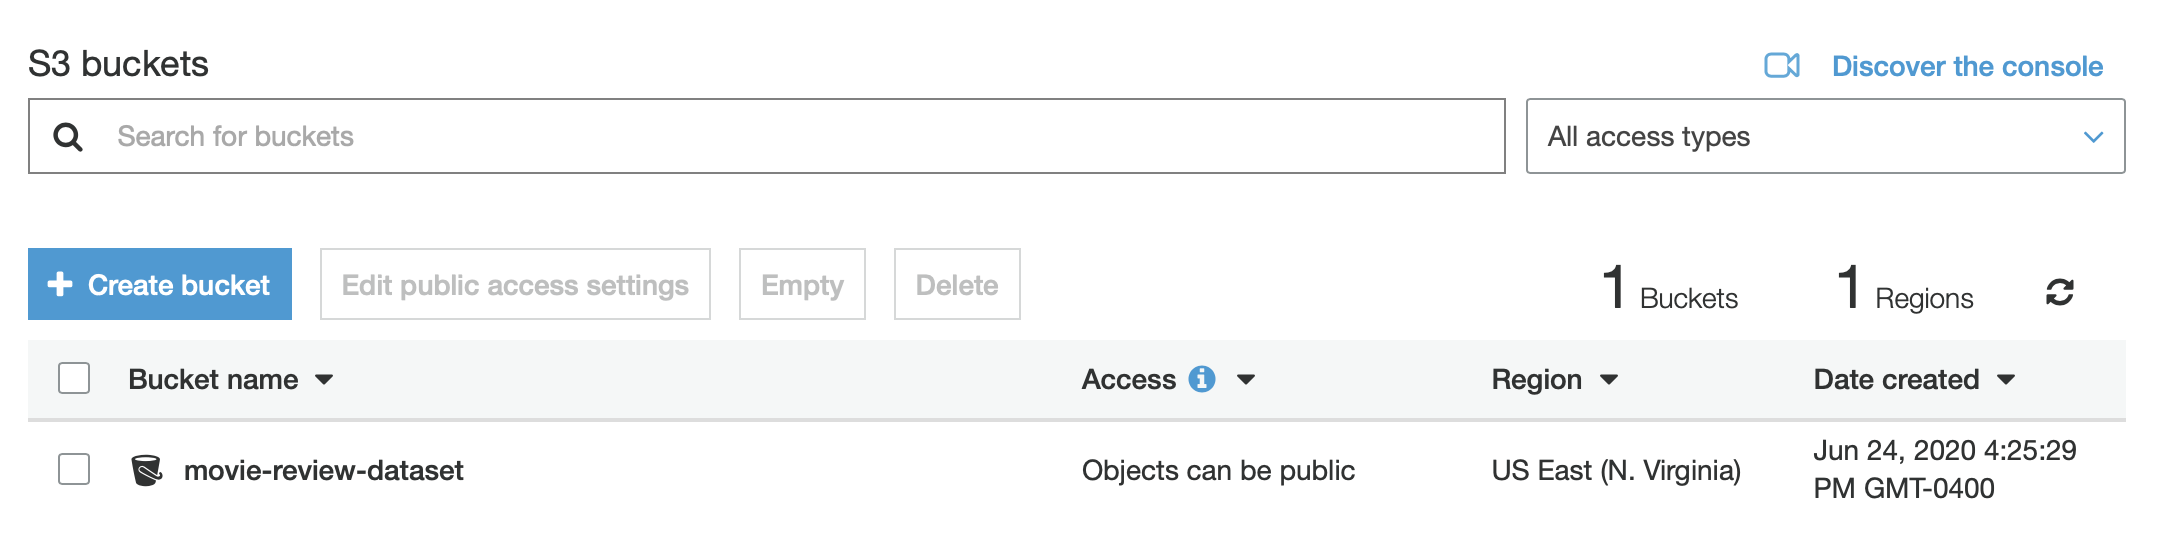

## 2. Model Training -- Movie review sentiment with BERT and TensorFlow2

The second step of this tutorial is model training. We will be using the IMDB movie review dataset to create a sentiment analysis model which contains 25K positive and negative movie reviews each. First, let's install the bert-for-tf2 package. 

In [ ]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 2.3MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=5f3374b29261a7a31e5ddeb2d661d5c326dd68e720d3897502670561b6fd2f74
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=3454cb699e6561be3b0787bd7b0d6e9af9a4ed711b6d11138b3ea7b11f96bf20
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=a43985d8a6541a645abc4514701aab9390d0a9d6c5840291c172d6e82a83f6a5
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [5]:
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

In [3]:
import os
import re
import sys
import math
import datetime
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [4]:
print ('Tensorflow: ', tf.__version__)
print ('Python: ', sys.version)

Tensorflow:  2.2.0
Python:  3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


### 2.1 Download Movie Review Data and BERT Weights

Here, we will download, extracts and import the IMDB large movie review dataset.

In [ ]:
from tensorflow import keras 
import os 
import re

# load all files from the directory into a dataframe
def load_directory_data(directory):
    data ={}
    data['sentence'] = []
    data['sentiment'] = []
    for file_path in os.listdir(directory): 
        with tf.io.gfile.GFile(os.path.join(directory, file_path), 'r') as f: 
    data['sentence'].append(f.read())
    data['sentiment'].append(re.match('\d+_(\d+)\.txt',file_path).group(1))
    return pd.DataFrame.from_dict(data)

# combine positive and negative reviews into a dataframe; add a polarity column 
def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, 'pos'))
    neg_df = load_directory_data(os.path.join(directory,'neg'))
    pos_df['polarity'] = 1
    neg_df['polarity'] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# download dataset from link
def download_and_load_datasets(force_download=False):
    dataset = tf.keras.utils.get_file(
        fname = 'acImbd.tar.gz',
        origin = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
        extract = True)
  
    train_df = load_dataset(os.path.join(os.path.dirname(dataset),"aclImdb",'train'))
    test_df = load_dataset(os.path.join(os.path.dirname(dataset),"aclImdb",'test'))

    return train_df, test_df

Let's use the MovieReviewData class below, to prepare/encode the data for feeding into our BERT model, by:
- tokenizing the text
- trim or pad it to a max_seq_len length
- append the special tokens [CLS] and [SEP]
- convert the string tokens to numerical IDs using the original model's token encoding from vocab.txt

In [ ]:
class MovieReviewData:
    DATA_COLUMN = 'sentence'
    LABEL_COLUMN = 'polarity'
    
    def __init__(self, tokenizer: FullTokenizer, sample_size =None, max_seq_len =1024):
        self.tokenizer = tokenizer
        self.sample_size = sample_size
        self.max_seq_len = 0
        train, test = download_and_load_datasets()

        train,test =map(lambda df: df.reindex(df[MovieReviewData.DATA_COLUMN].str.len().sort_values().index),[train,test])

        if sample_size is not None:
            train, test = train.head(sample_size), test.head(sample_size)
    
        ((self.train_x, self.train_y),
        (self.test_x, self.test_y)) = map(self._prepare, [train,test])

        print('max_seq_len', self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len,max_seq_len)
        ((self.train_x, self.train_x_token_types),
        (self.test_x, self.test_x_token_types)) = map(self._pad,[self.train_x , self.test_x])
      
    def _prepare(self,df):
        x,y =[],[]
        with tqdm(total =df.shape[0], unit_scale=True) as pbar:
            for ndx, row in df.iterrows():
                text, label = row[MovieReviewData.DATA_COLUMN], row[MovieReviewData.LABEL_COLUMN]
                tokens = self.tokenizer.tokenize(text)
                tokens = ['[CLS]'] + tokens + ['[SEP]']
                token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
                self.max_seq_len = max(self.max_seq_len , len(token_ids))
                x.append(token_ids)
                y.append(int(label))
                pbar.update()

    return np.array(x),np.array(y)

    def _pad(self,ids):
        x,t = [],[]
        token_type_ids = [0] * self.max_seq_len
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids),self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
            t.append(token_type_ids)
        return np.array(x), np.array(t)
        


This tutorial uses the pre-trained BERT model -- BERT-Base,Uncased, which could be downloaded here. https://github.com/google-research/bert. Users could save the BERT weights in the S3 bucket created early or use the local SageMaker enviroment and save the weights locally.

In [ ]:
assert_path = 'asset'
bert_model_name = 'uncased_L-12_H-768_A-12'
bert_ckpt_dir = os.path.join(assert_path , bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, 'bert_model.ckpt')
bert_config_file = os.path.join(bert_ckpt_dir, 'bert_config.json')

After getting both the IMDB movie review data and the BERT weights ready, we will use the S3 bucket to store these data by directly uploading them.

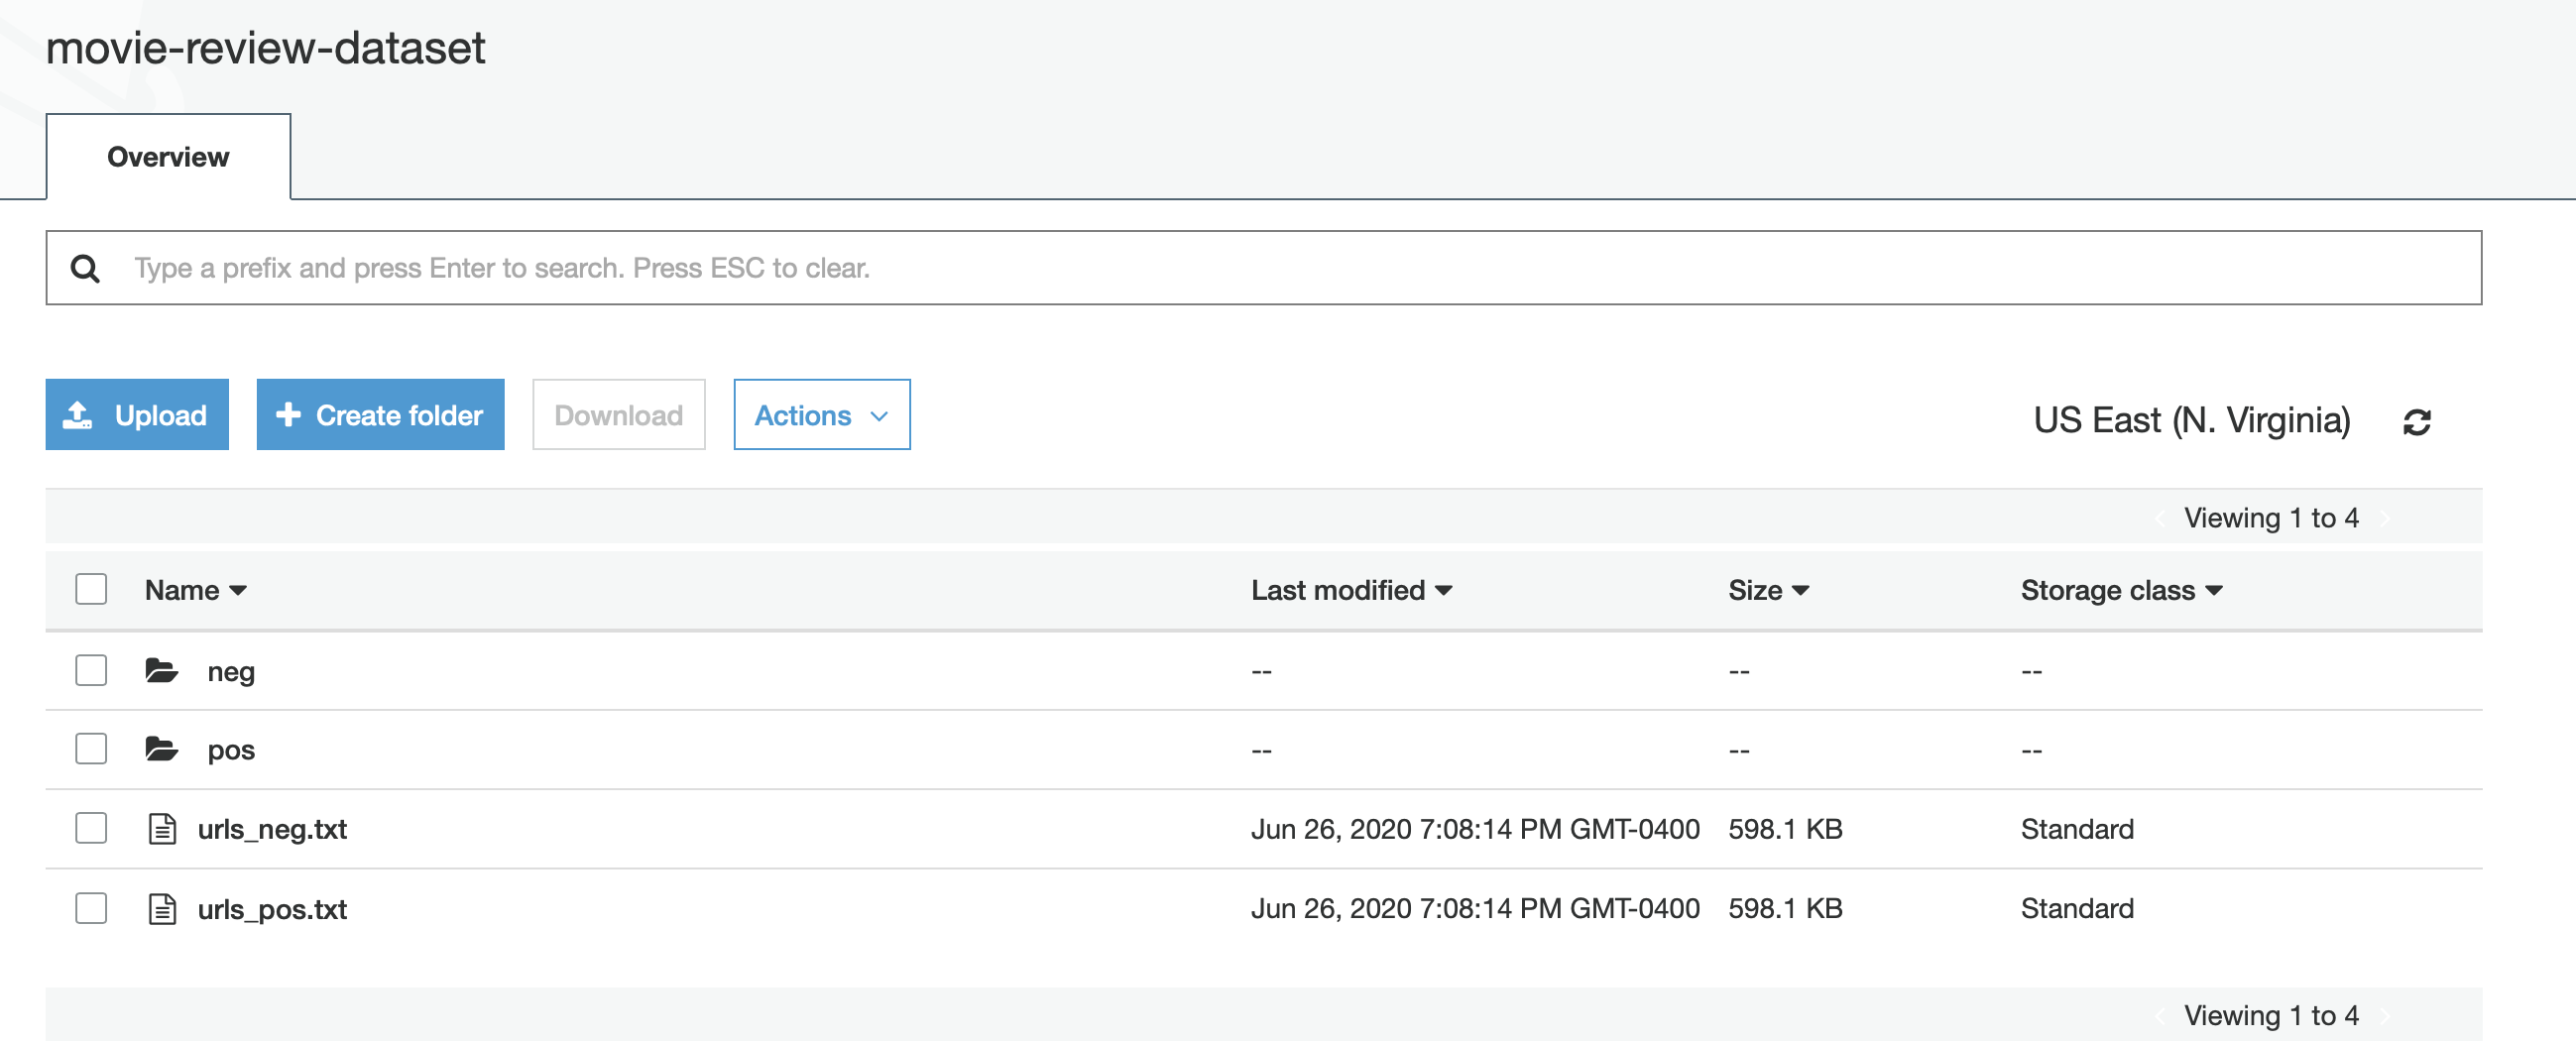

### 2.2 Data Preprocessing with Adapter BERT

In this step, we are ready to fetch the data using the BERT tokenizer. We will take the first 128 tokens by setting the max_seq_len = 128 and a sample size of 2500 each for train and test data due to transformer memory concerns.

In [ ]:
%%time

tokenizer = FullTokenizer(vocab_file =os.path.join(bert_ckpt_dir, 'vocab.txt'))
data = MovieReviewData(tokenizer, sample_size = 10*128*2, max_seq_len =128) # sample_size:5000

84131840/84125825 [==============================] - 3s 0us/step


100%|██████████| 2.56k/2.56k [00:02<00:00, 870it/s]
100%|██████████| 2.56k/2.56k [00:02<00:00, 874it/s]


max_seq_len 178
CPU times: user 23.5 s, sys: 8.87 s, total: 32.4 s
Wall time: 34.9 s


In [ ]:
print('train_x',data.train_x.shape)
print('train_x_token_types',data.train_x_token_types.shape)
print('train_y',data.train_y.shape)
print('test_x',data.test_x.shape)
print('max_seq_len',data.max_seq_len)

train_x (2560, 128)
train_x_token_types (2560, 128)
train_y (2560,)
test_x (2560, 128)
max_seq_len 128


In this tutorial, we will also be using Adapter BERT, which requires us to frezee the original BERT layers first. In short, adapter BERT is a more parameter efficient way for fine-tuning. Instead of using an entire new model for every task, adapter BERT adds only a few trainable parameters per task while achieving near state-of-the-art performance. For more information on adapter BERT, visit here: https://arxiv.org/abs/1902.00751

In [ ]:
def flatten_layers(root_layer):
    if isinstance(root_layer, keras.layers.Layer):
        yield root_layer
    for layer in root_layer._layers:
        for sub_layer in flatten_layers(layer):
            yield sub_layer


def freeze_bert_layers(l_bert):
    """
    Freezes all but LayerNorm and adapter layers - see arXiv:1902.00751.
    """
    for layer in flatten_layers(l_bert):
        if layer.name in ["LayerNorm", "adapter-down", "adapter-up"]:
            layer.trainable = True
        elif len(layer._layers) == 0:
            layer.trainable = False
        l_bert.embeddings_layer.trainable = False


def create_learning_rate_scheduler(max_learn_rate=5e-5,
                                   end_learn_rate=1e-7,
                                   warmup_epoch_count=10,
                                   total_epoch_count=90):

    def lr_scheduler(epoch):
        if epoch < warmup_epoch_count:
            res = (max_learn_rate/warmup_epoch_count) * (epoch + 1)
        else:
            res = max_learn_rate*math.exp(
                math.log(end_learn_rate/max_learn_rate)*(epoch-warmup_epoch_count+1)/(total_epoch_count-warmup_epoch_count+1))
        return float(res)
    learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

    return learning_rate_scheduler

### 2.3 Model Building and Training

Now, we are ready to create and train our model

In [ ]:
def create_model(max_seq_len, adapter_size =64):
    
    #create the bert layer
    with tf.io.gfile.GFile(bert_config_file, 'r') as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = adapter_size
        bert = BertModelLayer.from_params(bert_params, name = 'bert')

    input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name = 'input_ids')
    output = bert(input_ids)

    print('bert shape',output.shape)
    cls_out = keras.layers.Lambda(lambda seq: seq[:,0,:])(output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation='tanh')(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=2, activation = 'softmax')(logits)

    model = keras.Model(inputs = input_ids, outputs = logits)
    model.build(input_shape = (None, max_seq_len))

    load_stock_weights(bert, bert_ckpt_file)

    #freeze weights if adapter-BERT is used
    if adapter_size is not None:
        freeze_bert_layers(bert)
    
    model.compile(optimizer = keras.optimizers.Adam(),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics = [keras.metrics.SparseCategoricalAccuracy(name = 'acc')])
    model.summary()

    return model

In [ ]:
adapter_size = None 
model = create_model(data.max_seq_len, adapter_size = adapter_size) 

bert shape (None, 128, 768)
Done loading 196 BERT weights from: asset/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7febec1387b8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)         

In [ ]:
%%time
import datetime
log_dir = ".log/movie_reviews/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

total_epoch_count = 20
callbacks = [
             create_learning_rate_scheduler(max_learn_rate=1e-5,
                                                    end_learn_rate=1e-7,
                                                    warmup_epoch_count=20,
                                                    total_epoch_count=total_epoch_count),
            keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
            tensorboard_callback]

model.fit(x=data.train_x, y=data.train_y,
          validation_split = 0.1,
          batch_size = 12,
          shuffle=True,
          epochs = total_epoch_count,
          callbacks=callbacks
)



Epoch 00001: LearningRateScheduler reducing learning rate to 5.000000000000001e-07.
Epoch 1/20
192/192 [==============================] - 78s 404ms/step - loss: 0.7004 - acc: 0.5425 - val_loss: 0.6933 - val_acc: 0.5469 - lr: 5.0000e-07

Epoch 00002: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 2/20
192/192 [==============================] - 75s 390ms/step - loss: 0.6884 - acc: 0.5621 - val_loss: 0.6683 - val_acc: 0.5625 - lr: 1.0000e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 1.5000000000000002e-06.
Epoch 3/20
192/192 [==============================] - 74s 385ms/step - loss: 0.6484 - acc: 0.6176 - val_loss: 0.5679 - val_acc: 0.7734 - lr: 1.5000e-06

Epoch 00004: LearningRateScheduler reducing learning rate to 2.0000000000000003e-06.
Epoch 4/20
192/192 [==============================] - 76s 394ms/step - loss: 0.5064 - acc: 0.8125 - val_loss: 0.4224 - val_acc: 0.8906 - lr: 2.0000e-06

Epoch 00005: LearningRateScheduler reducing lear

In [ ]:
#save model weights
model.save_weights('./movie_review.h5', overwrite=True)

In [ ]:
%%time

_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print('train acc', train_acc)
print('test acc', test_acc)

80/80 [==============================] - 12s 155ms/step - loss: 0.3960 - acc: 0.9152
train acc 0.9742187261581421
test acc 0.915234386920929
CPU times: user 17.5 s, sys: 9.31 s, total: 26.8 s
Wall time: 27 s


### 2.4 Model Evaluation

For evaluation, let's load the previously saved model weights into a new model instance

In [ ]:
model = create_model(data.max_seq_len, adapter_size=None)
model.load_weights('./movie_review.h5')

bert shape (None, 128, 768)
Done loading 196 BERT weights from: asset/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f16a19737b8> (prefix:bert_3). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)     

Our model achieved a 91.5% accuracy on test data

In [ ]:
%%time

_, test_acc = model.evaluate(data.test_x, data.test_y)

print('test acc',test_acc)

80/80 [==============================] - 12s 155ms/step - loss: 0.3960 - acc: 0.9152
test acc 0.915234386920929
CPU times: user 9.57 s, sys: 4.67 s, total: 14.2 s
Wall time: 14.3 s


## 3 BentoML SageMaker API Endpoints Deployment

In this section, we will demonstrate on using BentoML to build production-ready API endpoints and deploy it to AWS SageMaker. The core steps are as follow:

1. Create a BentoML service file for model prediction <br>
2. Create and save a BentoMl packaged model called a BentoService bundle for model deployment<br>
3. Upload the BentoService bundle to cloud storage like S3 (optional)<br>
4. Use Bento CLI and its web UI for local testing<br> 
5. Deploy AWS SageMaker API endpoints through Bento CLI<br>
6. Use AWS CLI for endpoints testing<br>

Note: for AWS SageMaker deployment, you will need the following prerequisites: 1) Install and configure the AWS CLI
 2) Install Docker 

for more information, please click here: https://docs.bentoml.org/en/latest/deployment/aws_sagemaker.html

### 3.1 Create a BentoML Service File for Prediction

First, let's create a prediction service file using BentoML. The three main BentoML concepts are: 

1. Define the bentoml service environment 
2. Define the model artifacts based on the ML frameworks used for the trained model
3. Choose the relevant input adapters (formerly handlers) for the API

Note: BentoML supports a variety of major ML frameworks and input data format. For more details, please check available model artifacts here  
https://docs.bentoml.org/en/latest/api/artifacts.html and adapters here https://docs.bentoml.org/en/latest/api/adapters.html

For defining the BentoML service environment and trouble-shooting, you would also use `auto_pip_dependencies= True` or pass the BentoML generated requirement.txt through `@bentoml.env(requirements_tex_file ='./requirements.txt')`

In [19]:
%%writefile bentoml_service.py

import tensorflow as tf
import numpy as np
import pandas as pd

import bentoml
from bentoml.artifact import (TensorflowSavedModelArtifact, PickleArtifact)
from bentoml.adapters import DataframeInput

CLASSES  = ['negative','positive']
max_seq_len = 128

try:
    tf.config.set_visible_devices([],'GPU') 
except:
    pass

#define bentoml service environment
@bentoml.env(pip_dependencies=['tensorflow','bert','bert-for-tf2','numpy==1.18.1','pandas==1.0.1'])
#define model artifacts
@bentoml.artifacts([TensorflowSavedModelArtifact('model'), PickleArtifact('tokenizer')])

class Service(bentoml.BentoService):

    def tokenize(self, inputs: pd.DataFrame):
        tokenizer = self.artifacts.tokenizer
        if isinstance(inputs, pd.DataFrame):
            inputs = inputs.to_numpy()[:, 0].tolist()
        else: 
            inputs = inputs.tolist()
        pred_tokens = map(tokenizer.tokenize, inputs)
        pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
        pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))
        pred_token_ids = map(lambda tids: tids + [0] * (max_seq_len - len(tids)), pred_token_ids)
        pred_token_ids = tf.constant(list(pred_token_ids), dtype=tf.int32)
        return pred_token_ids
    
    # choose dataframe input adapter 
    @bentoml.api(input = DataframeInput(), md_max_latency = 300, mb_max_batch_size=20)
    def predict(self, inputs):
        model = self.artifacts.model
        pred_token_ids = self.tokenize(inputs)
        res = model(pred_token_ids).numpy().argmax(axis =-1)
        return [CLASSES[i] for i in res]

Overwriting bentoml_service.py


### 3.2 Create and Save BentoService Bundle

The following few lines of codes demonstrate the simplicity and time-saving benefits of using BentoML. Here, we first create a BentoService instance and then use the BentoService **pack method** to bundle our trained movie review model together. Finally, we use the BentoService **save method** to save this BentoService bundle, which is now ready for inference. This process eliminates the needs for reproducing the same prediction service for testing and production environment - making it easier for data science teams to deploy their models.

By default, the BentoService bundle is saved under `~/bentoml/repository/`directory. Users could also modify the model repository through BentoML's standalone component `YataiService`, for more information, please visit here: https://docs.bentoml.org/en/latest/concepts.html#model-management 


In [11]:
from bentoml_service import Service

#create a service instance for the movie review model
bento_svc = Service()

# pack model artifacts
bento_svc.pack('model',model)
bento_svc.pack('tokenizer',tokenizer)

#save the prediction service for model serving 
saved_path = bento_svc.save()

[2020-06-25 19:56:15,489] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be packaged together with saved bundle created, under './bundled_pip_dependencies' directory. For using a modified version of BentoML for production deployment, it is recommended to set the 'core/bentoml_deploy_version' config to a http location or your BentoML for on github, e.g.: 'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-06-25 19:56:15,927] WARNING - bert package does not exist in the current python session
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /private/var/folders/vn/bytl5x0n3vgg1vmg7n6qkqtc0000gn/T/bentoml-temp-35n_doz7/Service/artifacts/model_saved_model/assets
[2020-06-25 19:57:01,302] INFO - Detect BentoML installed in development model, copying local BentoML module file to target saved bundle path
running sdist
running egg_info
writ

no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'benchmark'


writing manifest file 'BentoML.egg-info/SOURCES.txt'
running check
creating BentoML-0.8.1+0.g5b6bd29.dirty
creating BentoML-0.8.1+0.g5b6bd29.dirty/BentoML.egg-info
creating BentoML-0.8.1+0.g5b6bd29.dirty/bentoml
creating BentoML-0.8.1+0.g5b6bd29.dirty/bentoml/adapters
creating BentoML-0.8.1+0.g5b6bd29.dirty/bentoml/artifact
creating BentoML-0.8.1+0.g5b6bd29.dirty/bentoml/cli
creating BentoML-0.8.1+0.g5b6bd29.dirty/bentoml/clipper
creating BentoML-0.8.1+0.g5b6bd29.dirty/bentoml/configuration
creating BentoML-0.8.1+0.g5b6bd29.dirty/bentoml/configuration/__pycache__
creating BentoML-0.8.1+0.g5b6bd29.dirty/bentoml/handlers
creating BentoML-0.8.1+0.g5b6bd29.dirty/bentoml/marshal
creating BentoML-0.8.1+0.g5b6bd29.dirty/bentoml/saved_bundle
creating BentoML-0.8.1+0.g5b6bd29.dirty/bentoml/server
creating BentoML-0.8.1+0.g5b6bd29.dirty/bentoml/server/static
creating BentoML-0.8.1+0.g5b6bd29.dirty/bentoml/utils
creating BentoML-0.8.1+0.g5b6bd29.dirty/bentoml/yatai
creating BentoML-0.8.1+0.g5b6bd

### Upload BentoService Bundle to S3 

As mentioned earlier, BentoML also provides ways to change the model repository - allowing data science teams to share the BentoService bundle easily for better collaborations. One way is by uploading it to the cloud services such as AWS S3. Using the same scripts as above and passing the S3 bucket URL into `.save()`, it will deploy the BentoService bundle directly into the S3 movie-review-dataset bucket we created earlier.

In [ ]:
from bentoml_service import Service

#create a service instance for the movie review model
bento_svc = Service()

# pack model artifacts
bento_svc.pack('model',model)
bento_svc.pack('tokenizer',tokenizer)

#save the prediction service to aws S3
saved_path = bento_svc.save(''s3://movie-review-dataset/'')

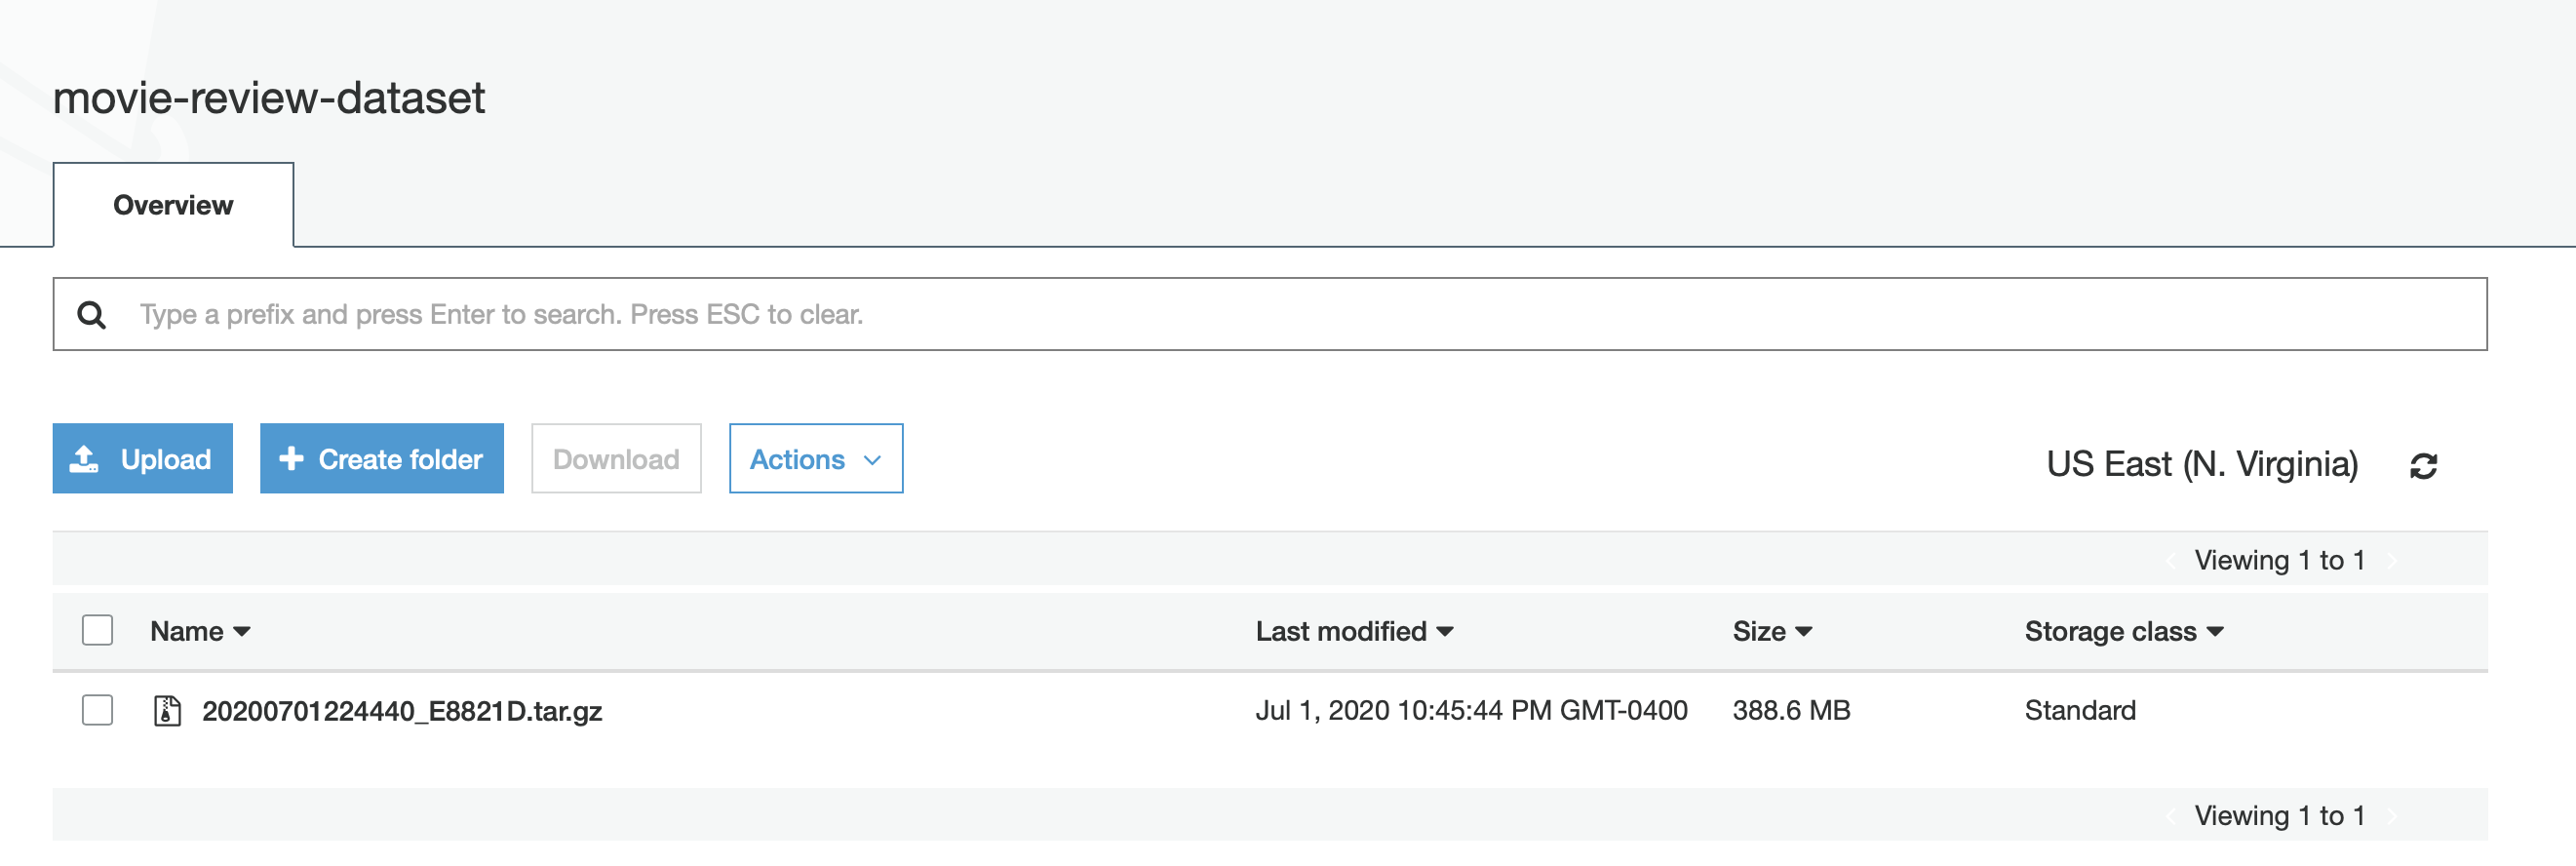

### 3.3  Show Existing BentoServices

Using the BentoML CLI, we can see a list of BentoService generated here

In [12]:
!bentoml list

BENTO_SERVICE                         AGE                 APIS                                   ARTIFACTS
Service:20200625195616_62D0DB         29.09 seconds       predict<DataframeInput:DefaultOutput>  model<TensorflowSavedModelArtifact>, tokenizer<PickleArtifact>
Service:20200622153915_614FE2         3 days and 4 hours  predict<DataframeInput:DefaultOutput>  model<TensorflowSavedModelArtifact>, tokenizer<PickleArtifact>
Service:20200622113634_A6EFDD         3 days and 8 hours  predict<DataframeInput:DefaultOutput>  model<TensorflowSavedModelArtifact>, tokenizer<PickleArtifact>
IrisClassifier:20200615204826_CAA9DD  1 week and 2 days   predict<DataframeInput:DefaultOutput>  model<SklearnModelArtifact>
IrisClassifier:20200615194906_60F775  1 week and 3 days   predict<DataframeInput:DefaultOutput>  model<SklearnModelArtifact>


### 3.4.1 Test REST API Locally -- Online API Serving

Before deploying the model to AWS SageMaker, we could test it locally first using the BentoML CLI. By using `bentoml serve`, it provides a near real-time prediction via API endpoints. 
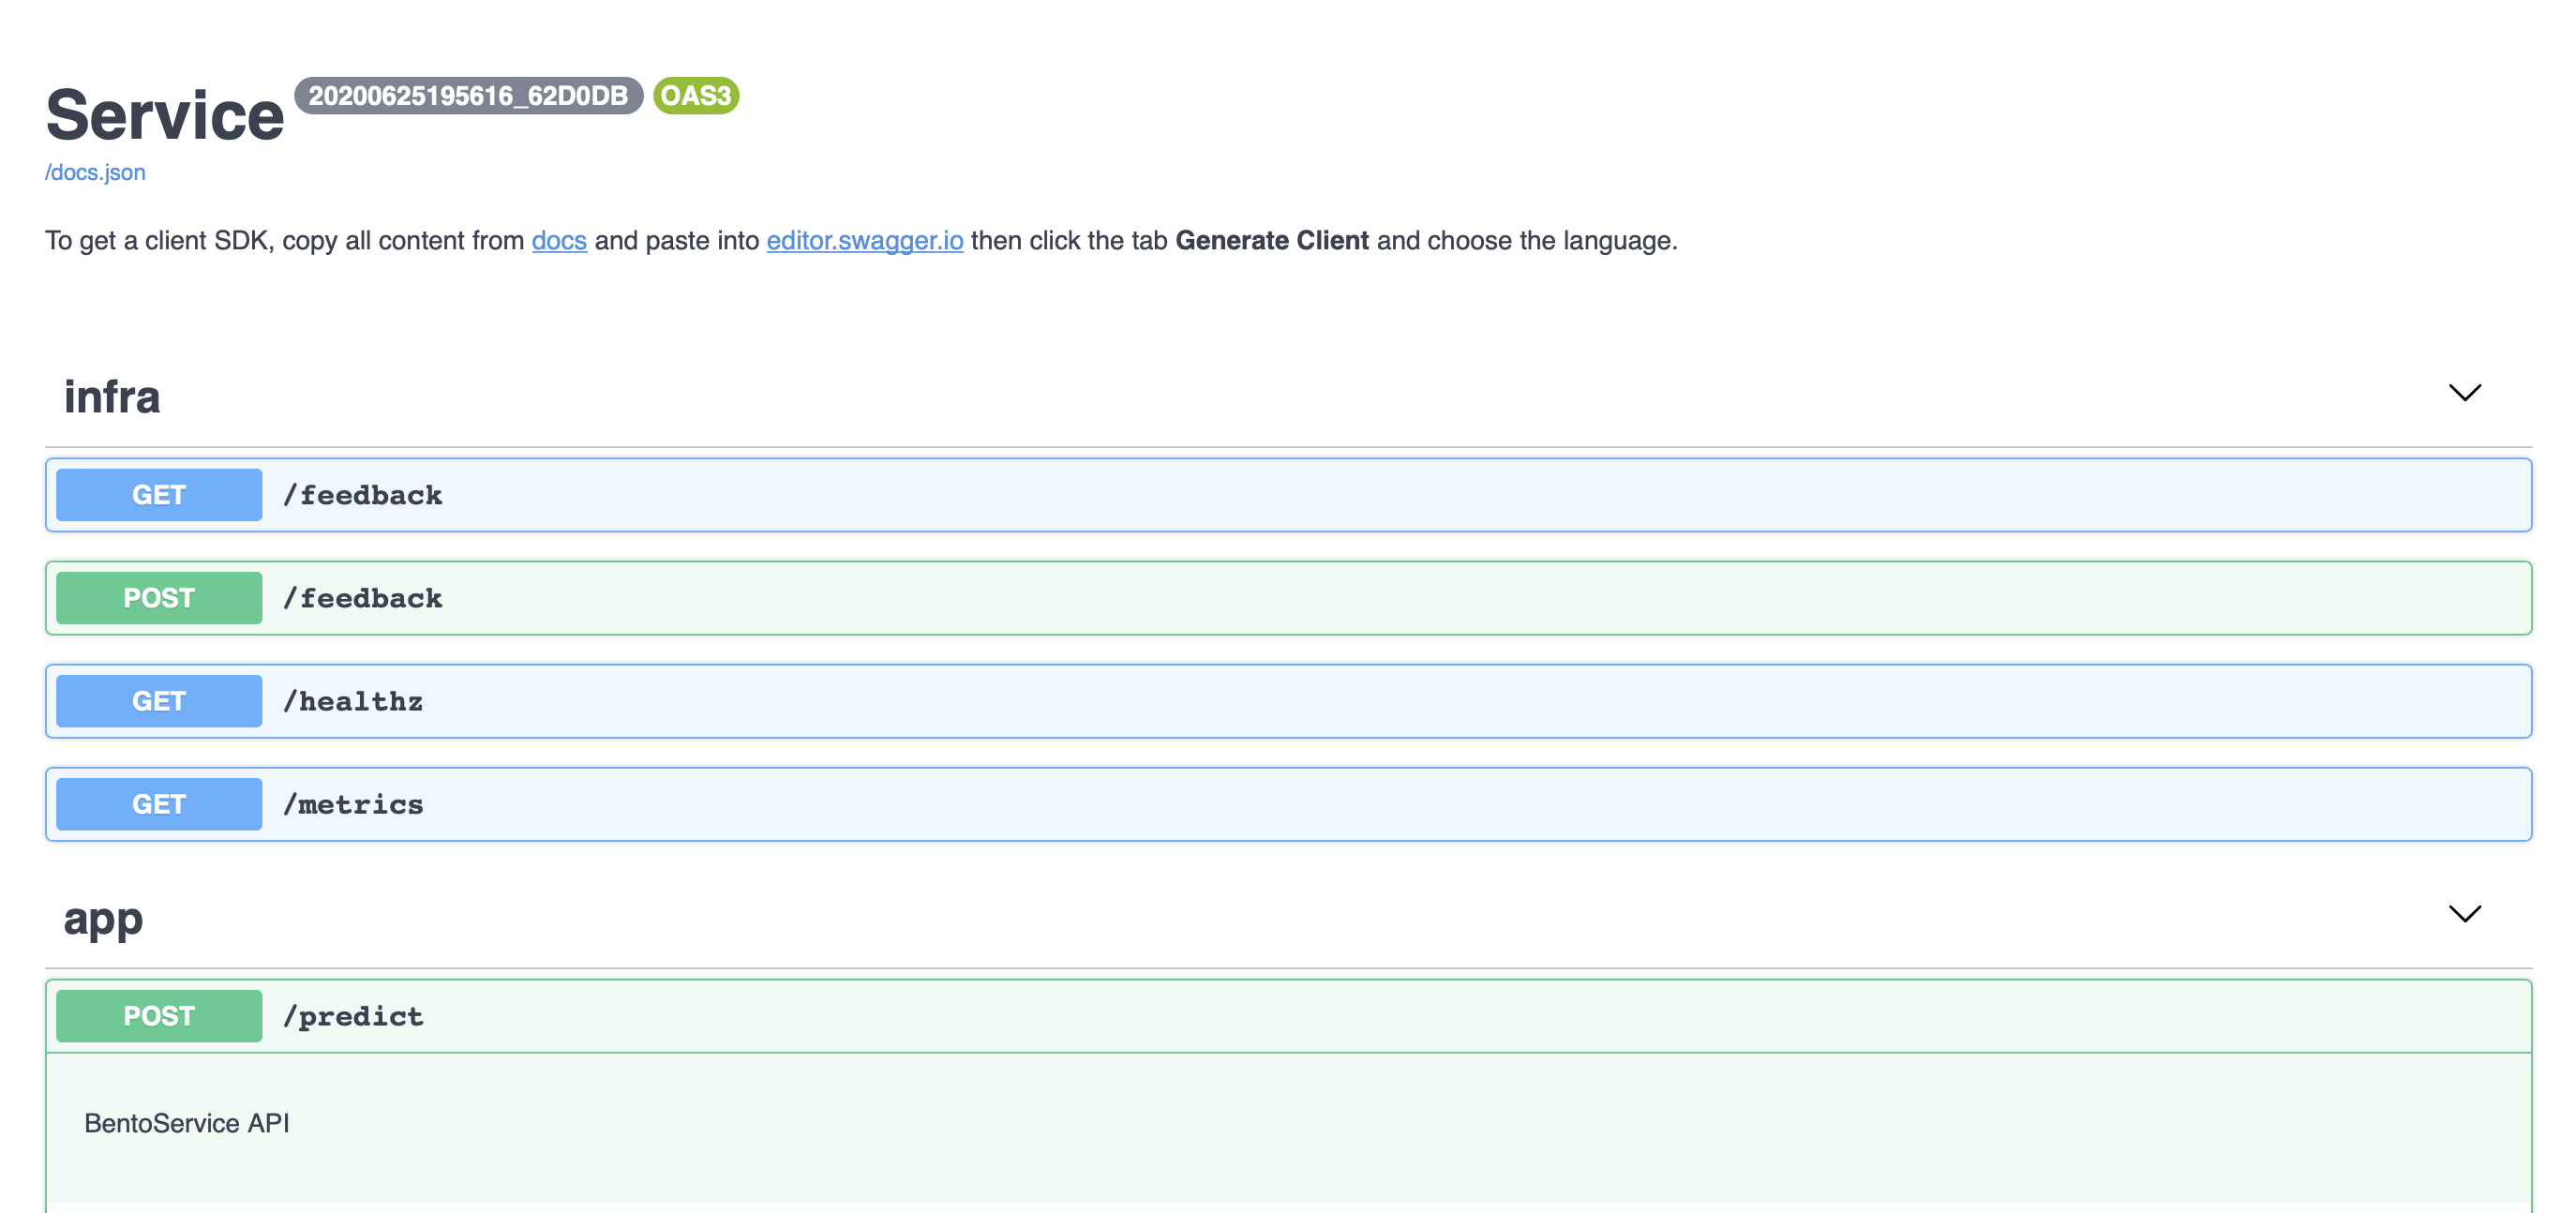

In [1]:
!bentoml serve Service:20200702134432_033DAB  

[2020-06-26 13:43:43,372] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be packaged together with saved bundle created, under './bundled_pip_dependencies' directory. For using a modified version of BentoML for production deployment, it is recommended to set the 'core/bentoml_deploy_version' config to a http location or your BentoML for on github, e.g.: 'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-06-26 13:43:43,399] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.1,  but loading from BentoML version 0.8.1+0.g5b6bd29.dirty
[2020-06-26 13:43:48,611] WARNING - bert package does not exist in the current python session
2020-06-26 13:43:49.603289: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2020-06-26 13:43:49.634653: I ten

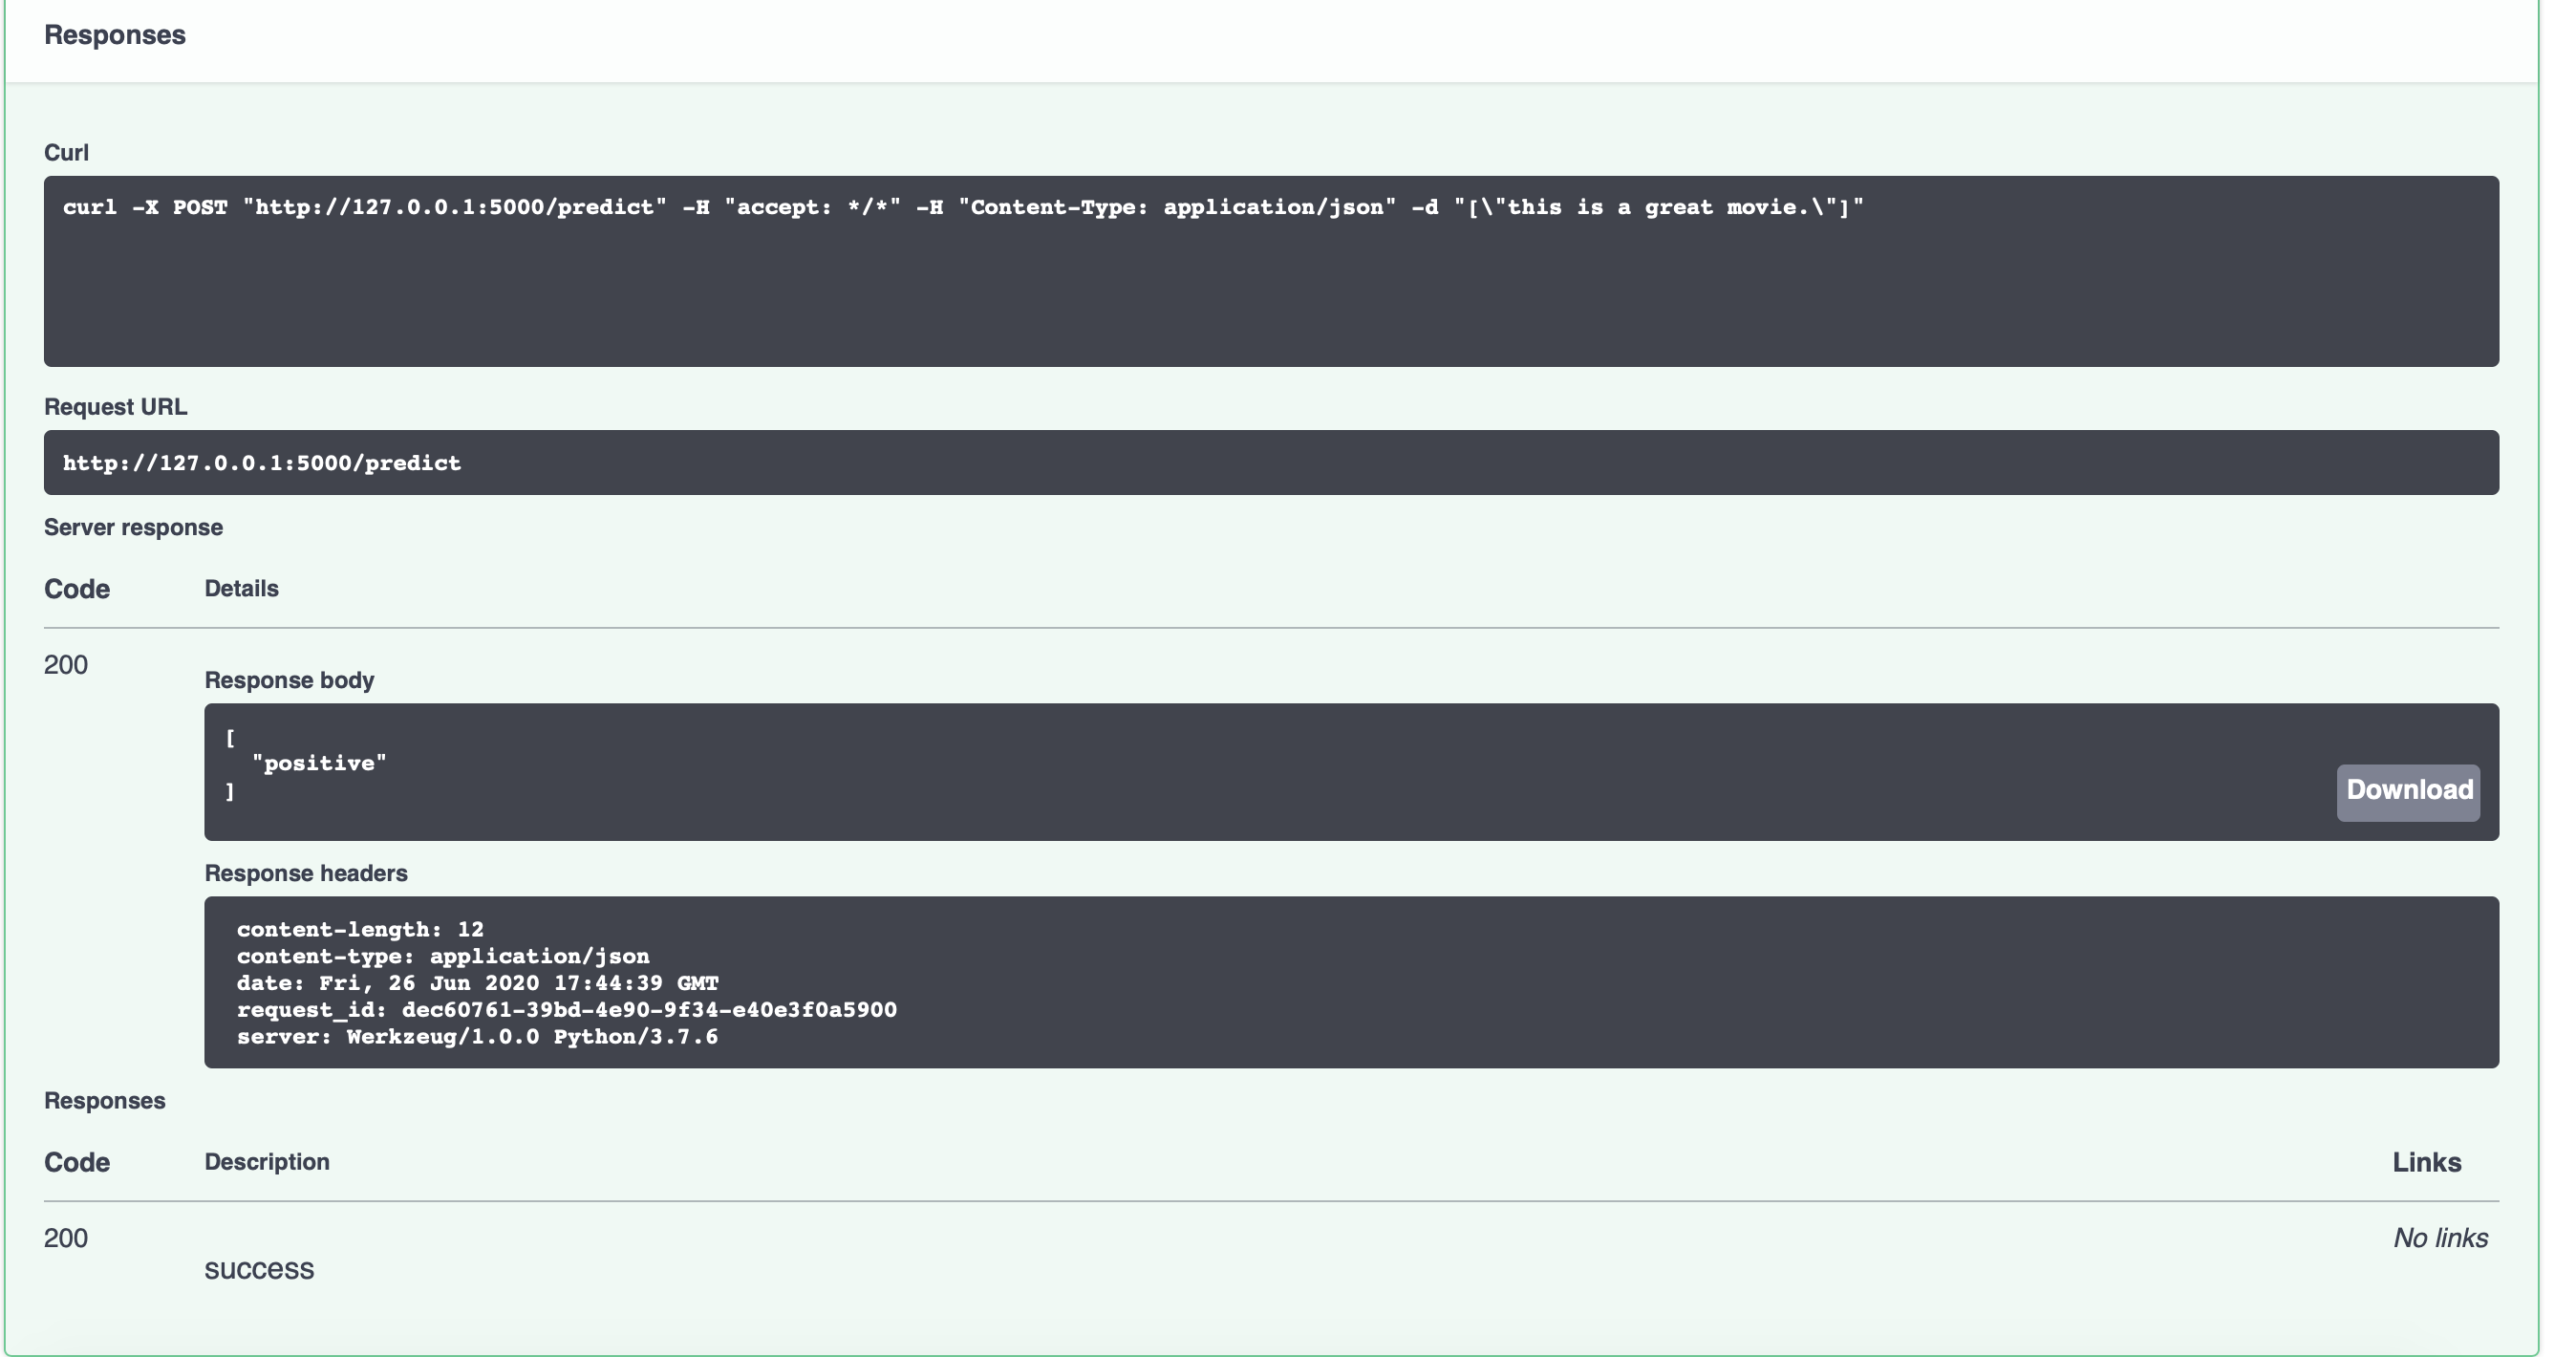

### 3.4.2 Test REST API Locally -- Offline Batch Serving

Alternatively, we could also use `bentoml run` for local testing. BentoML provides many other model serving methods, such as: adaptive micro-batching, edge serving,and programmatic access. Please visit here: https://docs.bentoml.org/en/latest/concepts.html#model-serving 

In [14]:
!bentoml run Service:20200702134432_033DAB   predict --input '["the acting was a bit lacking."]'

[2020-06-25 19:59:59,724] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be packaged together with saved bundle created, under './bundled_pip_dependencies' directory. For using a modified version of BentoML for production deployment, it is recommended to set the 'core/bentoml_deploy_version' config to a http location or your BentoML for on github, e.g.: 'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-06-25 19:59:59,747] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.1,  but loading from BentoML version 0.8.1+0.g5b6bd29.dirty
[2020-06-25 20:00:03,274] WARNING - bert package does not exist in the current python session
2020-06-25 20:00:04.447236: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2020-06-25 20:00:04.460749: I ten

### 3.5 Deploy to AWS SageMaker

Finally, we are ready to deploy our BentoML packaged model to AWS SageMaker. We need to pass the deployment name, the BentoService name and the API name. Depending on the size of the BentoService generated, the deployment for this tutorial took about 30mins.

In [16]:
!bentoml sagemaker deploy sagemaker-moviereview-deployment -b Service:20200702134432_033DAB  --api-name predict

Deploying Sagemaker deployment /[2020-06-25 20:16:14,382] INFO - Step 1/9 : FROM bentoml/model-server:0.8.1
[2020-06-25 20:16:14,383] INFO - 

[2020-06-25 20:16:14,383] INFO -  ---> e326316eaf10

[2020-06-25 20:16:14,383] INFO - Step 2/9 : ENV PORT 8080
[2020-06-25 20:16:14,384] INFO - 

[2020-06-25 20:16:14,384] INFO -  ---> Using cache

[2020-06-25 20:16:14,384] INFO -  ---> 1330be3b89a8

[2020-06-25 20:16:14,385] INFO - Step 3/9 : EXPOSE $PORT
[2020-06-25 20:16:14,385] INFO - 

[2020-06-25 20:16:14,385] INFO -  ---> Using cache

[2020-06-25 20:16:14,385] INFO -  ---> 77d1dc3ea8a0

[2020-06-25 20:16:14,385] INFO - Step 4/9 : RUN apt-get update --fix-missing &&     apt-get install -y nginx &&     apt-get clean
[2020-06-25 20:16:14,385] INFO - 

[2020-06-25 20:16:14,385] INFO -  ---> Using cache

[2020-06-25 20:16:14,385] INFO -  ---> d0803d90cbb0

[2020-06-25 20:16:14,385] INFO - Step 5/9 : RUN pip install gevent==1.4
[2020-06-25 20:16:14,385] INFO - 

[2020-06-25 20:16:14,385] INFO -

### 3.6 Check Endpoint Service Status

Here we could confirm that the API endpoints status is InService 

In [17]:
!aws sagemaker describe-endpoint --endpoint-name dev-sagemaker-moviereview-deployment

{
    "EndpointName": "dev-bert-moviereview-sagemaker",
    "EndpointArn": "arn:aws:sagemaker:us-east-1:899399195124:endpoint/dev-bert-moviereview-sagemaker",
    "EndpointConfigName": "dev-bert-moviereview-sagemaker-Service-20200625195616-62D0DB",
    "ProductionVariants": [
        {
            "VariantName": "dev-bert-moviereview-sagemaker-Service-20200625195616-62D0DB",
            "DeployedImages": [
                {
                    "SpecifiedImage": "899399195124.dkr.ecr.us-east-1.amazonaws.com/service-sagemaker:20200625195616_62D0DB",
                    "ResolvedImage": "899399195124.dkr.ecr.us-east-1.amazonaws.com/service-sagemaker@sha256:c064de18b75b18da26f5b8743491e13542a179915d5ea36ce4b8e971c6611062",
                    "ResolutionTime": "2020-06-25T20:53:14.176000-04:00"
                }
            ],
            "CurrentWeight": 1.0,
            "DesiredWeight": 1.0,
            "CurrentInstanceCount": 1,
            "DesiredInstanceCount": 1
        }
    ],
   

### 3.7 Test API Endpoints Using Boto3 SDK

Now, we are ready to test the SageMaker API endpoints by creating a small script using the boto3 SDK. Alternatively, users could also use the AWS CLI to test the endpoint. Please visit https://awscli.amazonaws.com/v2/documentation/api/latest/reference/sagemaker-runtime/invoke-endpoint.html

In [1]:
import boto3
import json

endpoint = 'dev-sagemaker-moviereview-deployment'
runtime = boto3.Session().client('sagemaker-runtime')

movie_example = '["The acting was a bit lacking."]'

response = runtime.invoke_endpoint(EndpointName=endpoint, ContentType='application/json', Body=movie_example)
# Unpack response
result = json.loads(response['Body'].read().decode())

print(result)

['negative']


## 4 Terminate AWS Resources 

Lastly, do not forget to terminate the AWS resources used in this tutorial. Users could also clean up used resources by logging into the SageMaker console. For more information, please see here:
https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html

In [4]:
bucket_to_delete = boto3.resource('s3').Bucket('movie-review-dataset')
bucket_to_delete.objects.all().delete()

[]

In [3]:
sagemaker.Session().delete_endpoint('dev-sagemaker-moviereview-deployment')